In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input, ReLU
from tensorflow.keras.layers import Dropout, InputLayer
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import tensorflow
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=100):
      # initialize the input shape to be "channels last" along with
      # the channels dimension itself
      # channels dimension itself
      inputShape = (height, width, depth)
      chanDim = -1

    # define the input to the encoder
      inputs = Input(shape=inputShape) # 48x32x3 - > 4 608
      x = inputs
      x = Conv2D(64, (4, 4), strides=2, padding="same")(x) # 24x16x64 -> 12 288
      x = LeakyReLU(0.2)(x)
      #x = Dropout(0.3)(x)
      x = BatchNormalization(axis=chanDim)(x)

      x = Conv2D(128, (4, 4), strides=2, padding="same")(x) # 12x8x128 -> 6 144
      x = LeakyReLU(0.2)(x)
      #x = Dropout(0.3)(x)
      x = BatchNormalization(axis=chanDim)(x)

      x = Conv2D(256, (4, 4), strides=2, padding="same")(x) # 6x4x256 -> 3 072
      x = LeakyReLU(0.2)(x)
      #x = Dropout(0.3)(x)
      x = BatchNormalization(axis=chanDim)(x)

      # flatten the network and then construct our latent vector
      volumeSize = K.int_shape(x)
      x = Flatten()(x) # 3 072
      latent = Dense(latentDim)(x) # latentDim
      # build the encoder model
      encoder = Model(inputs, latent, name="encoder")

       #decoder
      latentInputs = Input(shape=(latentDim,))
      x = Dense(np.prod(volumeSize[1:]))(latentInputs)
      
      x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

      x = Conv2DTranspose(256, (4, 4), strides=2,
            padding="same")(x)
      x = LeakyReLU(0.2)(x)
      #x = Dropout(0.3)(x)
      x = BatchNormalization(axis=chanDim)(x)

      x = Conv2DTranspose(128, (4, 4), strides=2,
            padding="same")(x)
      x = LeakyReLU(0.2)(x)
      #x = Dropout(0.3)(x)
      x = BatchNormalization(axis=chanDim)(x)

      x = Conv2DTranspose(64, (4, 4), strides=2,
            padding="same")(x)
      x = LeakyReLU(0.2)(x)
      #x = Dropout(0.3)(x)
      x = BatchNormalization(axis=chanDim)(x)

      #apply a single CONV_TRANSPOSE layer used to recover the
      # original depth of the image
      x = Conv2DTranspose(depth, (4, 4), padding="same")(x)
      outputs = x#Activation("tanh")(x)
      # build the decoder model
      decoder = Model(latentInputs, outputs, name="decoder")
      # our autoencoder is the encoder + decoder
      autoencoder = Model(inputs, decoder(encoder(inputs)),
                          name="autoencoder")
      # return a 3-tuple of the encoder, decoder, and autoencoder
      return (encoder, decoder, autoencoder)

In [ ]:
drive = 'drive/My Drive/margonem_assets_generation/denoising/'
train_set = np.load(drive + 'train_dataset_for_denoising.npy')
test_set = np.load(drive + 'test_dataset_for_denoising.npy')

x_train = train_set[:, 0]
y_train = train_set[:, 1]
x_test = test_set[:, 0]
y_test = test_set[:, 1]

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(100600, 48, 32, 3)
(100600, 48, 32, 3)
(9435, 48, 32, 3)
(9435, 48, 32, 3)


In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

# initialize the number of epochs to train for and batch size
EPOCHS = 20
BATCH_SIZE = 256
INIT_LR = 1e-3

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(32, 48, 3, filters=(32, 64), latentDim=2048)

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt, metrics=['mae'])
# train the convolutional autoencoder
H = autoencoder.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE)
autoencoder.save_weights(drive + 'correcting_ae.h5')

#autoencoder.load_weights(drive + 'correcting_ae.h5')

[INFO] building autoencoder...
Epoch 1/20
393/393 [==============================] - 116s 296ms/step - loss: 0.1390 - mae: 0.2405 - val_loss: 0.1744 - val_mae: 0.3330
Epoch 2/20
393/393 [==============================] - 115s 292ms/step - loss: 0.0678 - mae: 0.1692 - val_loss: 0.0713 - val_mae: 0.1750
Epoch 3/20
393/393 [==============================] - 115s 294ms/step - loss: 0.0470 - mae: 0.1424 - val_loss: 0.0579 - val_mae: 0.1573
Epoch 4/20
393/393 [==============================] - 115s 293ms/step - loss: 0.0373 - mae: 0.1273 - val_loss: 0.0558 - val_mae: 0.1550
Epoch 5/20
393/393 [==============================] - 115s 294ms/step - loss: 0.0327 - mae: 0.1184 - val_loss: 0.0567 - val_mae: 0.1592
Epoch 6/20
393/393 [==============================] - 115s 293ms/step - loss: 0.0303 - mae: 0.1129 - val_loss: 0.0540 - val_mae: 0.1537
Epoch 7/20
393/393 [==============================] - 115s 294ms/step - loss: 0.0290 - mae: 0.1094 - val_loss: 0.0521 - val_mae: 0.1491
Epoch 8/20
393/39

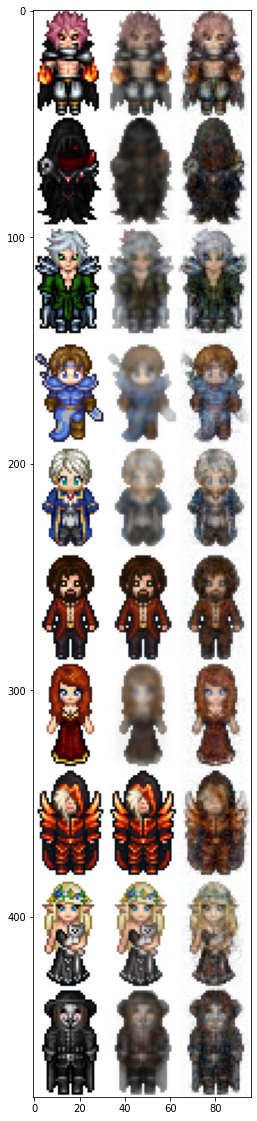

In [ ]:
import matplotlib.pyplot as plt

indices = np.random.choice(len(x_test), replace=False, size=10)
sample_x_test = x_test[indices]
sample_y_test = y_test[indices]
preds = autoencoder.predict(sample_x_test)
img = np.concatenate((sample_x_test, sample_y_test, preds), axis=2)
img = np.concatenate(img, axis=0)
img = (img + 1.0) * 127.5
img = np.round(img)
img = np.clip(img, 0, 255)
img = img.astype(np.uint8)
plt.figure(figsize=(20,20))
plt.imshow(img)

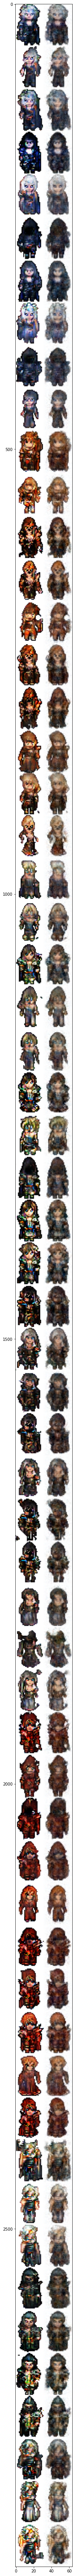

In [ ]:
generated_dataset = np.load(drive + 'DCGAN_generated.npy')
generated_corrected = autoencoder.predict(generated_dataset)
img = np.concatenate((generated_dataset, generated_corrected), axis=2)
img = np.concatenate(img, axis=0)
img = (img + 1.0) * 127.5
img = np.round(img)
img = np.clip(img, 0, 255)
img = img.astype(np.uint8)
plt.figure(figsize=(120,120))
plt.imshow(img)

In [ ]:
generated_dataset = np.load(drive + 'DCGAN_generated_noisy_v2.npy')
generated_dataset = np.clip(generated_dataset, -1, 1)[:, 1:3]
preds = []
for img in generated_dataset:
  pred = autoencoder.predict(img)
  pred = img.mean(axis=0)
  preds.append(pred)
generated_corrected = np.array(preds)
img = np.concatenate((generated_dataset[:, 0],
                      #generated_dataset[:, 1],
                      #generated_dataset[:, -1],
                      generated_corrected), axis=2)
img = np.concatenate(img, axis=0)
img = (img + 1.0) * 127.5
img = np.round(img)
img = np.clip(img, 0, 255)
img = img.astype(np.uint8)
plt.figure(figsize=(120,120))
plt.imshow(img)

In [ ]:
from scipy.signal import convolve2d
from scipy.ndimage.filters import gaussian_filter

def get_most_frequent_color(data):
    lst = [(i,j,k) for i,j,k in zip(data[:,:,:,0].ravel(),
                                    data[:,:,:,1].ravel(),
                                    data[:,:,:,2].ravel())]
    lst = lst[:1000]
    most_frequent_color = max(set(lst), key=lst.count)
    return most_frequent_color

def get_mask(data, most_frequent_color):
    mask = (data[:, :, :, 0] != most_frequent_color[0]) |\
           (data[:, :, :, 1] != most_frequent_color[1]) |\
           (data[:, :, :, 2] != most_frequent_color[2])
           
    lst = []
    for i in range(mask.shape[0]):
        lst.append(np.pad(mask[i], 1, 'constant', constant_values=False))
    mask_padded = np.array(lst)
    filter = np.ones((3, 3))
    for i in range(mask_padded.shape[0]):
        conv_out = convolve2d(mask_padded[i], filter, mode='valid')
        m = conv_out >= 7
        conv_out[m] = True
        conv_out[~m] = False
        conv_out = conv_out.astype(bool)
        mask[i] = mask[i] | conv_out
        mask[i] = mask[i] | conv_out
    return mask

def blur(data, mask, sigma=0.5, background_factor=0.9):
    arr = data[:, :, :, :-1]
    blurred = gaussian_filter(arr, sigma)
    arr[mask] = blurred[mask]
    arr[~mask] = blurred[~mask] * (1.0 - background_factor) + arr[~mask] * background_factor
    data[:, :, :, :-1] = arr
    return data

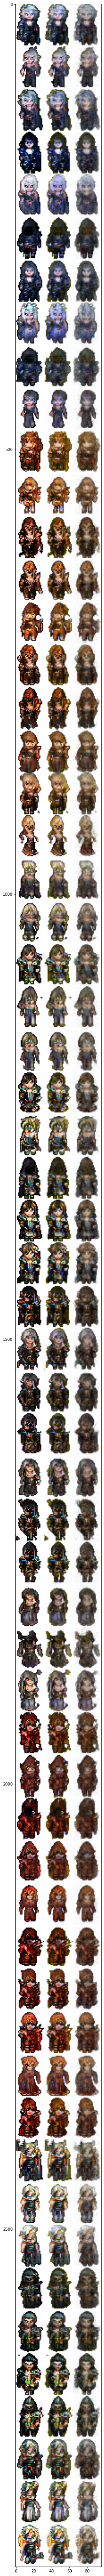

In [ ]:
generated_dataset_noisy = generated_dataset.copy()
color = get_most_frequent_color(generated_dataset_noisy)
mask = get_mask(generated_dataset_noisy, color)
generated_dataset_noisy = blur(generated_dataset_noisy, mask, 0.5)

generated_corrected = autoencoder.predict(generated_dataset_noisy)
img = np.concatenate((generated_dataset, generated_dataset_noisy, generated_corrected), axis=2)
img = np.concatenate(img, axis=0)
img = (img + 1.0) * 127.5
img = np.round(img)
img = np.clip(img, 0, 255)
img = img.astype(np.uint8)
plt.figure(figsize=(120,120))
plt.imshow(img)